In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/faceexpressions1/data.csv
/kaggle/input/faceexpressions1/dataset/Surprise/cropped_emotions.269276~12fffff.png
/kaggle/input/faceexpressions1/dataset/Surprise/cropped_emotions.264079~12fffff.png
/kaggle/input/faceexpressions1/dataset/Surprise/cropped_emotions.260019~12fffff.png
/kaggle/input/faceexpressions1/dataset/Surprise/cropped_emotions.267910~12fffff.png
/kaggle/input/faceexpressions1/dataset/Surprise/cropped_emotions.414980~12fffff.png
/kaggle/input/faceexpressions1/dataset/Surprise/cropped_emotions.267632~12fffff.png
/kaggle/input/faceexpressions1/dataset/Surprise/cropped_emotions.259996~12fffff.png
/kaggle/input/faceexpressions1/dataset/Surprise/cropped_emotions.261356~12fffff.png
/kaggle/input/faceexpressions1/dataset/Surprise/cropped_emotions.260140~12fffff.png
/kaggle/input/faceexpressions1/dataset/Surprise/cropped_emotions.265897~12fffff.png
/kaggle/input/faceexpressions1/dataset/Surprise/cropped_emotions.100080~12fffff.png
/kaggle/input/faceexpressions1/datas

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps

In [8]:
# data importing
def load_data(image_folder):
    images = []
    labels = []

    for expression in os.listdir(image_folder):
        expression_dir = os.path.join(image_folder, expression)
        for img_name in os.listdir(expression_dir):
            img_path = os.path.join(expression_dir, img_name)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((128, 128))
            images.append(img)
            labels.append(expression)

    return images, labels

In [11]:
dataset= '/kaggle/input/faceexpressions1/dataset'

In [15]:
# Loading the dataset folder which has images
base_dir = dataset
batch_size = 64
img_size = 128
seed_value=100

In [16]:
training_set = tf.keras.utils.image_dataset_from_directory(
# Directory path
base_dir,
# No labels are needed
label_mode=None,
# Split 20% for validation
validation_split=0.2,
# Subset for training
subset="training",
# Seed for reproducibility
seed=100,
# Image dimensions
image_size=(img_size, img_size),
# Batch size
batch_size=batch_size,
# Color mode: RGB
color_mode='rgb'
)

Found 15453 files.
Using 12363 files for training.


In [17]:
validation_set = tf.keras.utils.image_dataset_from_directory(
# Directory path
base_dir,
label_mode=None,
# Split 20% for validation
validation_split=0.2,
# Subset for validation
subset="validation",
# Seed for reproducibility
seed=100,
# Image dimensions
image_size=(img_size, img_size),
# Batch size
batch_size=batch_size,
# Color mode: RGB
color_mode='rgb'
)



Found 15453 files.
Using 3090 files for validation.


In [18]:
# Normalization of img_pixels
training_set = training_set.map(lambda x: x / 255.0)
validation_set = validation_set.map(lambda x: x / 255.0)

In [21]:
#Step 1: Encoding
# Define latent dimension for the encoder
latent_dim = 2
# Define input shape for the encoder
input_shape = (img_size, img_size, 3)
# Define input layer for the encoder
inputs = Input(shape=input_shape, name='encoder_input')
# First convolutional layer with ReLU activation, 32 filters, stride 2, and same padding
x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
# Second convolutional layer with ReLU activation, 64 filters, stride 2, and same padding
x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
# Get shape before flattening for later use
shape_before_flattening = K.int_shape(x)
# Flatten the convolutional output
x = Flatten()(x)
# Dense layer to compute the mean of the latent space
z_mean = Dense(latent_dim)(x)
# Dense layer to compute the log variance of the latent space
z_log_var = Dense(latent_dim)(x)

In [22]:
# defining Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# Use Lambda layer to integrate sampling function into the model
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# Initialize the model #1
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 65536)     │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2)         │    131,074 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │    131,074 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 281,540 (1.07 MB)

 Trainable params: 281,540 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#Step 3: Decoder network
# Input layer for the decoder, sampling from latent space
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# Fully connected layer to reshape into the shape before flattening
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(latent_inputs)
# Reshape layer to match shape before flattening
x = Reshape(shape_before_flattening[1:])(x)
# Transposed convolutional layer with ReLU activation, 64 filters, stride 2, and same padding
x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
# Transposed convolutional layer with ReLU activation, 32 filters, stride 2, and same padding
x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
# Output layer with sigmoid activation for color images
outputs = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)
# Initialize the model #2
decoder = Model(latent_inputs, outputs, name='decoder')
# Print model summary
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 65536)          │       196,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,867 (987.76 KB)

 Trainable params: 252,867 (987.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
#Ensure the encoder and decoder output shapes are equal
# VAE model
#Decode sampled latent vector (z) into reconstructed outputs
outputs = decoder(z)
# Initialize VAE
vae = Model(inputs, outputs, name='vae_mlp')
# Print a summary of the VAE model architecture
vae.summary()

Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 65536)     │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2)         │    131,074 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │    131,074 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 128, 128,  │    252,867 │ z[0][0]           │
│ (Functional)        │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 534,407 (2.04 MB)

 Trainable params: 534,407 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Custom layer for VAE loss calculation
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # Calculate binary cross-entropy reconstruction loss
        decoded_img_loss = binary_crossentropy(K.flatten(x), K.flatten(x_decoded_mean))
        decoded_img_loss *= img_size * img_size * 3
        # Calculate KL divergence loss
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        # Calculate VAE loss as the mean of reconstruction loss and KL loss
        vae_loss = K.mean(decoded_img_loss + kl_loss)
        # Add VAE loss to the layer
        self.add_loss(vae_loss)
        # Return the decoded mean output
        return x_decoded_mean
# Instantiate the VAE loss layer with inputs
vae_outputs = VAELossLayer()([inputs, outputs, z_mean, z_log_var])
# Instantiate the VAE model with inputs and VAE loss outputs
vae = Model(inputs, vae_outputs, name='vae')
# Compile the VAE model with Adam optimizer
vae.compile(optimizer='adam')

In [26]:
# Fit the VAE model
history = vae.fit(training_set, epochs=10, batch_size=batch_size, validation_data=validation_set)

Epoch 1/10
  5/194 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 34049.5703

I0000 00:00:1721764601.481061     171 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


194/194 ━━━━━━━━━━━━━━━━━━━━ 37s 143ms/step - loss: 32239.0742 - val_loss: 30519.6250
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - loss: 30494.7051 - val_loss: 30502.2852
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - loss: 30476.5176 - val_loss: 30481.8770
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - loss: 30454.3184 - val_loss: 30469.9395
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - loss: 30456.8574 - val_loss: 30459.9336
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - loss: 30439.7676 - val_loss: 30472.4668
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - loss: 30428.2617 - val_loss: 30474.0859
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 42s 124ms/step - loss: 30413.4844 - val_loss: 30472.4824
Epoch 9/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - loss: 30420.8086 - val_loss: 30467.6836
Epoch 10/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - loss: 30419.9863 - val_loss: 30510.0488


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


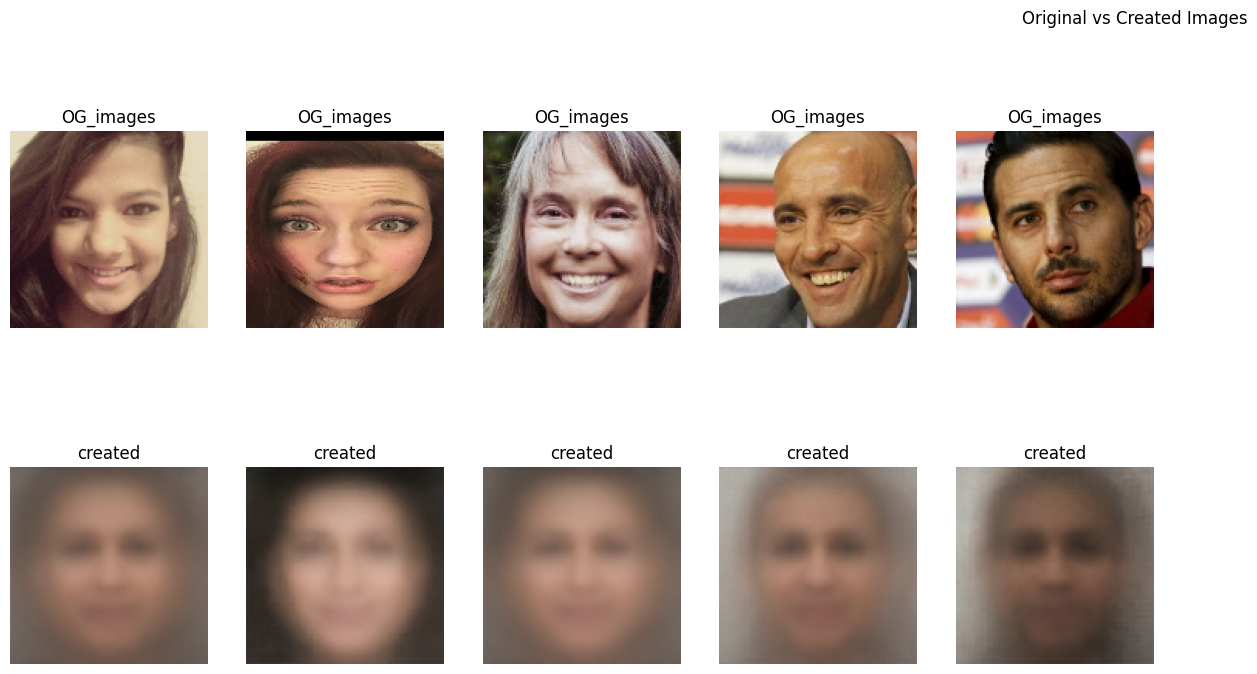

In [27]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
# Take a batch of images from the validation set
for og_images in validation_set.take(10):
    display_img_config= (og_images.numpy() * 255).astype('uint8')
    z_mean, _, _ = encoder.predict(og_images)
    # predicting decoded images
    created_images = decoder.predict(z_mean)
    # Scaling the decoded images
    created_img_display = (created_images * 255).astype('uint8')
    plt.figure(figsize=(30, 8))

    for i in range(5):
        # Display Original images
        axes = plt.subplot(2, 10, i + 1)
        plt.imshow(display_img_config[i])
        plt.title("OG_images")
        plt.axis("off") #turn "on" to see the axis values
       # Display created images
        axes = plt.subplot(2, 10, i + 1 + 10)
        plt.imshow(created_img_display[i])
        plt.title("created")
        plt.axis("off") #turn "on" to see the axis values
    plt.suptitle("Original vs Created Images", fontsize=12, x=0.5, ha="center")
    plt.show()
    break

In [33]:
# Save the model as an .h5 file
vae.save('my_model.h5')

# Move the model file to the output directory
import shutil
shutil.move('my_model.h5', '/kaggle/my_model.h5')


'/kaggle/my_model.h5'

In [31]:
# Save the model as an .h5 file
vae.save('mymodel.h5')

# Create a link to download the file
import IPython
from IPython.display import FileLink

# Move the model file to the current working directory (optional if not already there)
!mv mymodel.h5 /kaggle/working/

# Display the download link
display(FileLink('/kaggle/working/mymodel.h5'))


mv: 'mymodel.h5' and '/kaggle/working/mymodel.h5' are the same file


/kaggle/working/mymodel.h5